### 這支程式將載入岩心盒的12類原始標籤

In [46]:
import supervision as sv
from roboflow import Roboflow
from pycocotools.coco import COCO
import pycocotools.mask as mask_utils
import os
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [38]:
#12類別對應顏色
color_map = {0:[0, 0, 0], #背景
             1:[242, 194, 111], 2:[219, 148, 55], 3:[181, 114, 27], #泥
             4:[181, 114, 27], 5:[242, 238, 7], #細砂
             6:[173, 247, 77], 7:[117, 240, 50],8:[117, 240, 50], #粗砂
             9:[45, 210, 247], 10:[45, 136, 247], 11:[24, 42, 237], 12:[30, 13, 122]} #礫石

---

### 從roboflow載入標好標籤的coco json

In [7]:
rf = Roboflow(api_key="*********")
project = rf.workspace("steven102789").project("core_tray")
version = project.version(6)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to core_tray-6 in coco-segmentation:: 100%|██████████| 23/23 [00:00<00:00, 534.75it/s]


In [4]:
#從網路下在好資料後讀取其資料
# location_path = dataset.location
#讀取本地照片
location_path = './core_tray-6/'
train_ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{location_path}/train",
    annotations_path=f"{location_path}/train/_annotations.coco.json",
)

In [5]:
json_path = f"{location_path}/train/_annotations.coco.json"
save_mask = "../raw_data/13_label/"
coco = COCO(json_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


---

### 簡單示範下載下來的mask與照片比對

In [40]:
#從json取得image id
images_ids = coco.getImgIds()
images_count = len(images_ids)
print(f'共有{images_count}張照片')

共有19張照片


In [31]:
img_index = 6
# 根据图像唯一id获取对应信息
img_info = coco.loadImgs(images_ids)[img_index]
# 其對應照片路徑
img_files_path = os.path.join(location_path+'/train', img_info['file_name'])
# 获取所有类别的 ID
category_ids = coco.getCatIds()
# 获取所有类别的信息
categories = coco.loadCats(category_ids)
# 取得照片大小
height, width = img_info['height'], img_info['width']
# 根据图像id获取对应标签信息
ann_ids = coco.getAnnIds(imgIds=images_ids[img_index])
anns = coco.loadAnns(ann_ids) 
img_info

{'id': 6,
 'license': 1,
 'file_name': '020251G1_8_12_png.rf.160db6f965c738d2b6ba4325316a7bf0.jpg',
 'height': 256,
 'width': 256,
 'date_captured': '2024-07-29T07:54:55+00:00',
 'extra': {'user_tags': ['020251G1']}}

In [32]:
# 创建类别到ID的映射
category_to_id = {category['name']: category['id'] for category in categories}
category_to_id

{'rock_object': 0,
 '1-': 1,
 '2-': 2,
 '3-': 3,
 '4-': 4,
 '5-': 5,
 '6-': 6,
 '7-': 7,
 '8-': 8,
 '90-': 9,
 '91-': 10,
 '92-': 11,
 '93-': 12}

In [33]:
# 创建一个全零的矩阵，用于存储掩码
mask = np.zeros((height, width), dtype=np.uint8)
print(f"==>> mask: {mask.shape}")
# 逐实例处理（一个图像存在多个实例）
for ann in anns:
    category_id = ann['category_id']
    
    # 获取 RLE 编码
    rle = coco.annToRLE(ann)
    # 解码为二值掩码
    binary_mask = mask_utils.decode(rle)
    
    # 将二值掩码中的 1 替换为类别 ID
    mask[binary_mask == 1] = category_id

==>> mask: (256, 256)


In [34]:
# 获取矩阵中的所有唯一元素
unique_elements = np.unique(mask)
# 打印唯一元素
print("Unique elements in the matrix:", unique_elements)

Unique elements in the matrix: [ 0  2  5  6  8  9 10]


In [35]:
def display_image_with_colored_mask(mask:np.array, 
                                    img_path:str, 
                                    color_map:dict, 
                                    title:str):
    """
    显示原图像和彩色掩码图像

    参数：
    - mask: 掩码矩阵
    - img_path: 图像文件路径
    - color_map: 标签到颜色的映射字典
    - title: 图像标题（可选）
    """
    # 创建一个彩色图像数组
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    # 根据掩码矩阵的值设置彩色图像数组的颜色
    for label, color in color_map.items():
        color_mask[mask == label] = color
    
    # 读取图像
    image = cv2.imread(img_path)

    # 显示原图像和彩色掩码图像
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # 原图像
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f'Original Image')
    ax[0].axis('off')

    # 彩色掩码图像
    ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[1].imshow(color_mask, alpha=0.5)  # 叠加透明的彩色掩码图像
    ax[1].set_title('Colored Mask')
    ax[1].axis('off')
    # 添加主标题
    if title:
        plt.suptitle(title, fontsize=16)

    plt.show()
def get_joined_str_from_filename(file_name, delimiter='_', parts=3):
    """
    获取文件名的前三部分并连接成一个字符串

    参数：
    - file_name: 文件名字符串
    - delimiter: 分隔符（默认为下划线）
    - parts: 需要获取的部分数量(默认为3)

    返回：
    - joined_str: 连接后的字符串
    """
    parts = file_name.split(delimiter)[:parts]
    joined_str = delimiter.join(parts)
    return joined_str

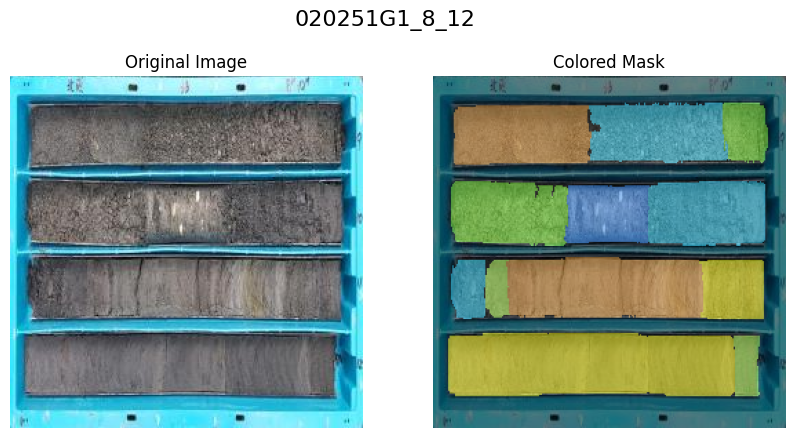

In [36]:
img_name = get_joined_str_from_filename(img_info['file_name'])
display_image_with_colored_mask(mask, img_files_path, color_map, img_name)

---

### 批量製造mask進raw_label/13_label

In [48]:
for i in tqdm(range(images_count)):
    # 根据图像唯一 id 获取对应信息
    img_info = coco.loadImgs(images_ids[i])[0]
    
    # 根据图像 id 获取对应标签信息
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)
    
    # 取得名称
    img_name = get_joined_str_from_filename(img_info['file_name'])
    
    # 取得照片大小
    height, width = img_info['height'], img_info['width']
    
    # 制作空 array 放 mask
    mask = np.zeros((height, width), dtype=np.uint8)
    
    for ann in anns:
        category_id = ann['category_id']
        
        # 获取 RLE 编码
        rle = coco.annToRLE(ann)
        
        # 解码为二值掩码
        binary_mask = mask_utils.decode(rle)
        
        # 将二值掩码中的 1 替换为类别 ID
        mask[binary_mask == 1] = category_id
    
    # 将数组保存为 PNG 图片
    output_image = Image.fromarray(mask)
    output_image.save(f'../raw_data/13_label/{img_name}.png')


100%|██████████| 19/19 [00:00<00:00, 245.74it/s]
